# Imports

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

# Pystan Model Setup

In [3]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

# Data Generation

In [4]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

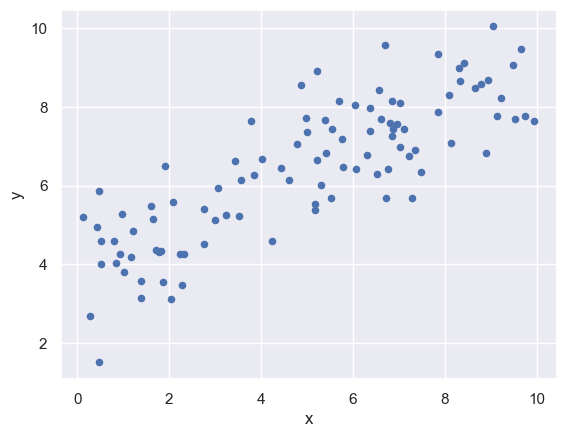

In [5]:
# Plotting the data

df = pd.DataFrame({'x': x, 'y': y})
df.plot.scatter(x='x', y='y');

# Sampling

In [6]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


In [7]:
fit

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  6.6e-3    0.2   3.47   3.72   3.84   3.99   4.26    937    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.58    952    1.0
sigma   1.01  2.3e-3   0.07   0.88   0.96   1.01   1.06   1.17    962    1.0
lp__  -50.66    0.05   1.24 -53.93 -51.18 -50.32 -49.77 -49.28    677    1.0

Samples were drawn using NUTS at Mon Aug 29 22:04:22 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [8]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

# Plotting the Regression Line

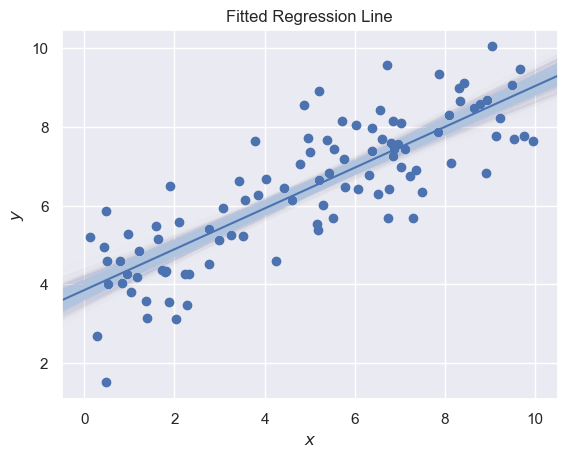

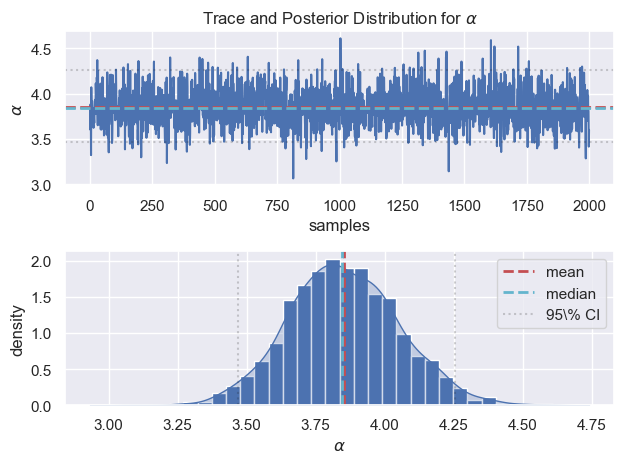

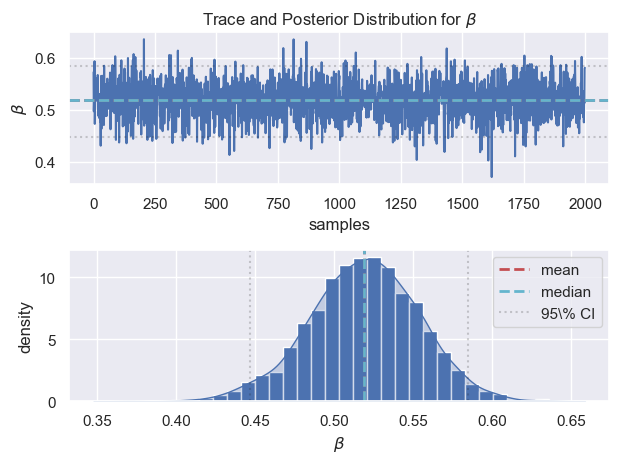

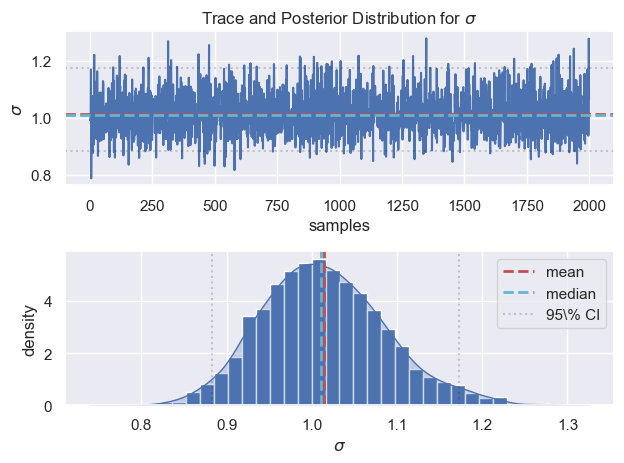

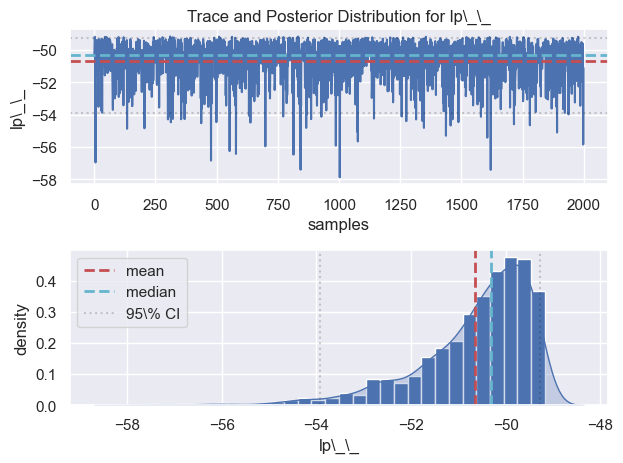

In [9]:
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
for i in np.random.randint(0, len(alpha), 1000):
  plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.005)

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()


def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

plot_trace(alpha, r'$\alpha$') 
plt.show()
plot_trace(beta, r'$\beta$') 
plt.show()
plot_trace(sigma, r'$\sigma$') 
plt.show()
plot_trace(lp, r'lp\_\_') 
plt.show()